In [1]:
import numpy as np
import matplotlib.pyplot as plt
from train import get_parser
from ssd.config.defaults import cfg
from ssd.data.build import make_data_loader
from vizer.draw import draw_boxes
np.random.seed(0)

In [2]:
config_path = "configs/train_waymo_Copy1.yaml"
cfg.merge_from_file(config_path)
cfg.freeze()
cfg.INPUT.PIXEL_MEAN

[123, 117, 104]

In [3]:
#Do not need to run
# data_loader = make_data_loader(cfg, is_train=True)
# if isinstance(data_loader, list):
#     print(list)
#     data_loader = data_loader[0]
# dataset = data_loader.dataset
# indices = list(range(len(dataset)))
#np.random.shuffle(indices)

In [4]:
# idx = indices[1]
# image = dataset._read_image(idx)
# boxes, labels = dataset.get_annotation(idx)
# image = draw_boxes(
#     image, boxes, labels, class_name_map=dataset.class_names
# )
# plt.figure(figsize=(20, 12))
# plt.imshow(image)
#plt.imsave("visualization.png", image)
#print("Saved the image to visualization.png")

In [5]:
#The codes above is designed by the TA of tdt4265
#The flowing part is designed by Xiaoyu to understand the data augmentations

In [6]:
from ssd.data.transforms.transforms import *
from torchvision import transforms

In [7]:
#Dive into the data loading
import pathlib
from PIL import Image
import json

def _read_image(index):
    data_dir = "datasets/waymo"
    data_dir =pathlib.Path(data_dir)
    image_id = index
    image_path = data_dir.joinpath("images").joinpath(f"{image_id}.jpg")
    image = Image.open(str(image_path)).convert("RGB")
    image = np.array(image)
    return image
def _get_annotation(image_id,labels):
    label = labels[image_id]
    bbox_key = "bounding_boxes"
    if bbox_key not in label:
        bbox_key = "bboxes"
    boxes = np.zeros((len(label[bbox_key]), 4), dtype=np.float32)
    labels = np.zeros((len(label[bbox_key])), dtype=np.int64)
    for idx, bounding_box in enumerate(label[bbox_key]):
        box = [
            bounding_box["xmin"],
            bounding_box["ymin"],
            bounding_box["xmax"],
            bounding_box["ymax"]]
        boxes[idx] = box
        labels[idx] = bounding_box["label_id"]
    # SSD use label 0 as the background. Therefore +1
    labels = labels + 1
    return boxes, labels
def read_labels(label_path):
    assert label_path.is_file(), \
        f"Did not find label file: {label_path.absolute()}"
    with open(label_path, "r") as fp:
        labels = json.load(fp)
    labels_processed = {}
    for label in labels:
        image_id = label["image_id"]
        labels_processed[image_id] = label
    return labels_processed

In [8]:
def random_crop(im, boxes, labels):
    imh, imw, _ = im.shape
    short_size = min(imh, imw)
    while True:
        # 选择任意一个crop pitch
        mode = random.randint(0, 4)
        for _ in range(10):
            if mode == 0:
                w = short_size
            else:
                w = random.randrange(int(0.3*short_size), short_size)   # 从0.3倍的最小边界开始
            h = w
            print('w',w,'h',h)

            x = random.randint(0, imw - w)
            y = random.randint(0, imh - h)   # 随机选择正方形区域
            roi = torch.Tensor([x, y, x+w, y+h])

            center = (boxes[:, :2]+boxes[:, 2:]) / 2   # (N,2)维, 中心点
            roi2 = roi.expand(len(center), 4)          # 把(1,4)expand到(N,4)维
            # 1. 选择包含box的roi
            mask = (center > roi2[:, :2]) & (center < roi2[:, 2:])  # crop pitch里面包含那个中心点(N,2)
            mask = mask[:, 0] & mask[:, 1]  # (N, 1)
            # any对每个元素进行或运算，对每个元素进行与运算
#             if not mask.any():   # 如果全为零，舍弃这个crop patch
#                 im, boxes, labels = self.random_getim()
#                 imh, imw, _ = im.shape
#                 short_size = min(imh, imw)
#                 continue

            selected_boxes = boxes.index_select(0, mask.nonzero().squeeze(1))  # mask变为(N,)
            img = im[y:y+h, x:x+w]    # 裁剪区域
            selected_boxes[:,0].add_(-x).clamp_(min=0, max=w)    # clamp 夹并在x,y之间
            selected_boxes[:,1].add_(-y).clamp_(min=0, max=h)
            selected_boxes[:,2].add_(-x).clamp_(min=0, max=w)
            selected_boxes[:,3].add_(-y).clamp_(min=0, max=h)

            # expand_as(x) 表示扩展成x的尺寸
            boxes_uniform = selected_boxes / torch.Tensor([w,h,w,h]).expand_as(selected_boxes)
            boxeswh = boxes_uniform[:, 2:] - boxes_uniform[:, :2]

            # 2. 选择去掉box太小的
            mask = (boxeswh[:,0] > self.small_threshold) & (boxeswh[:,1] > self.small_threshold)
            if not mask.any():   # 若全部为零，则舍弃
                im, boxes, labels = self.random_getim()
                imh, imw, _ = im.shape
                short_size = min(imh, imw)
                continue

            selected_boxes_selected = selected_boxes[mask.nonzero().squeeze(1)]   # mask变为(N,)
            selected_labels = labels.index_select(0, mask.nonzero().squeeze(1))
            return img, selected_boxes_selected, selected_labels 

In [9]:
#get the image '1.jpg' and relating box and label
idx = 1
print(idx)
image_test=_read_image(idx)
data_dir = "datasets/waymo"
data_dir =pathlib.Path(data_dir)
label_total=read_labels(data_dir.joinpath("labels.json"))
label_test=_get_annotation(idx,label_total)
box_test=label_test[0] 
label_test = label_test[1]
class_test='__background__', 'vehicle', 'person', 'sign', 'cyclist'

1


In [10]:
# print('image_test',image_test)
# print('label_test',label_test)
# print('box_test',box_test)

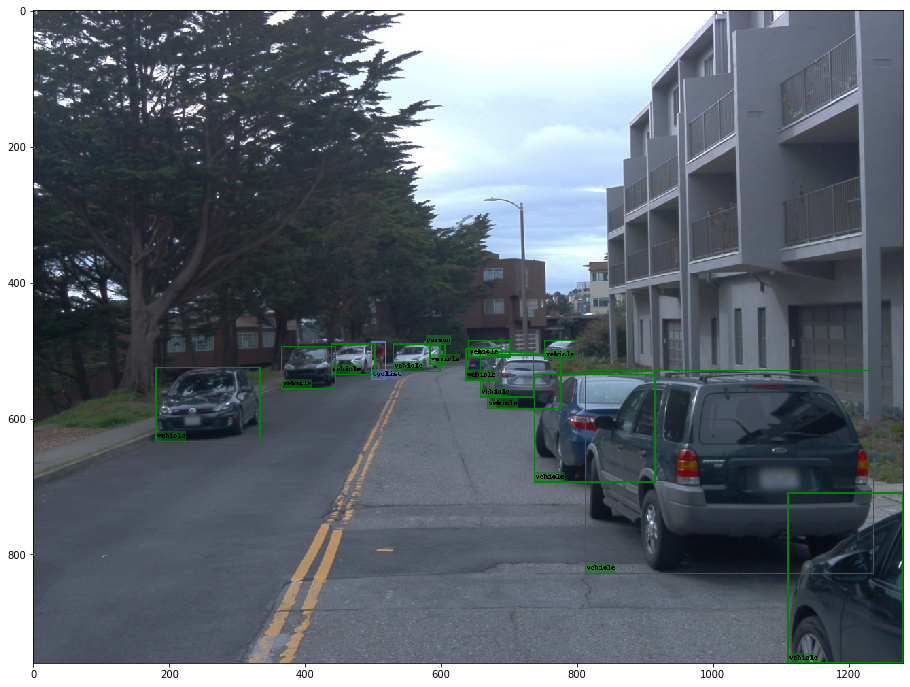

In [11]:
#Show the original version of the '1.jpg'
image_show = draw_boxes(
    image_test, box_test, label_test, class_name_map=class_test)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [12]:
#Dive into different Data transforms

In [13]:
#This is the data augmentation used in Xiaoyu's code
t1=ConvertFromInts()
t2=colorJitter()
t3=RandomErasing()
#t2=PhotometricDistort()
t4=Expand(cfg.INPUT.PIXEL_MEAN)
t5=RandomSampleCrop()
t6=RandomMirror()
t7=ToPercentCoords()
t8=Resize(cfg.INPUT.IMAGE_SIZE)
t9=SubtractMeans(cfg.INPUT.PIXEL_MEAN)
t10=ToPILImage()

In [14]:
#t1=ConvertFromInts()
img,box,label=t1(image_test,box_test,label_test)

In [15]:
# print('img',img)
# print('box',box)
# print('label',label)

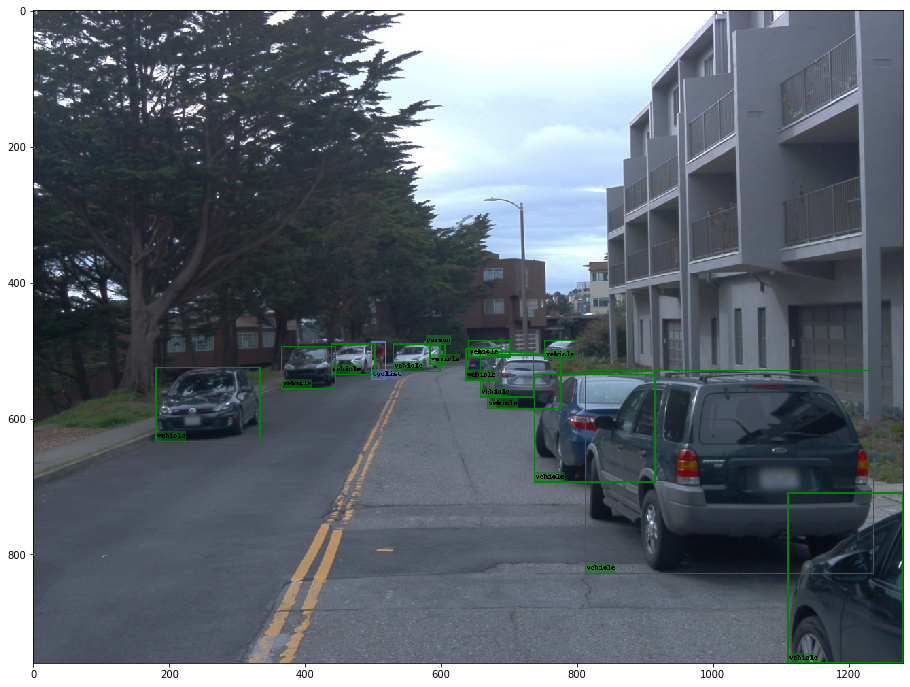

In [16]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [17]:
#t2 is colorJitter()
img,box,label=t2(img,box,label) 

In [18]:

#print('img',img)
# print('box',box)
# print('label',label)

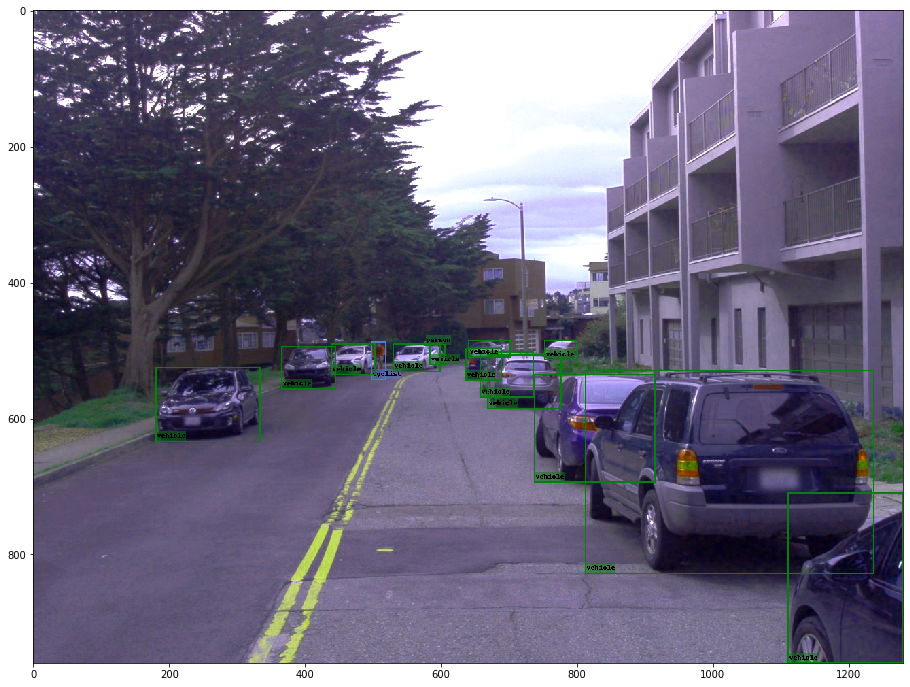

In [19]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [24]:
#t3 is Expand
img,box,label=t3(img,box,label) 

In [ ]:
# print('img',img)
# print('box',box)
# print('label',label)

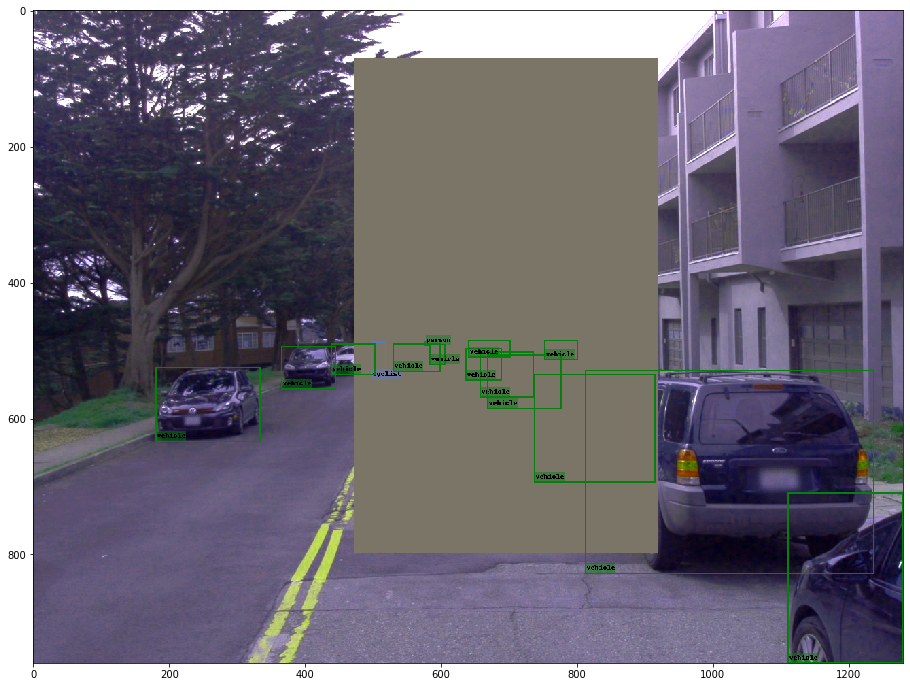

In [25]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [26]:
#t4=RandomSampleCrop()
img,box,label=t4(img,box,label)

In [27]:
# print('img',img)
# print('box',box)
# print('label',label)

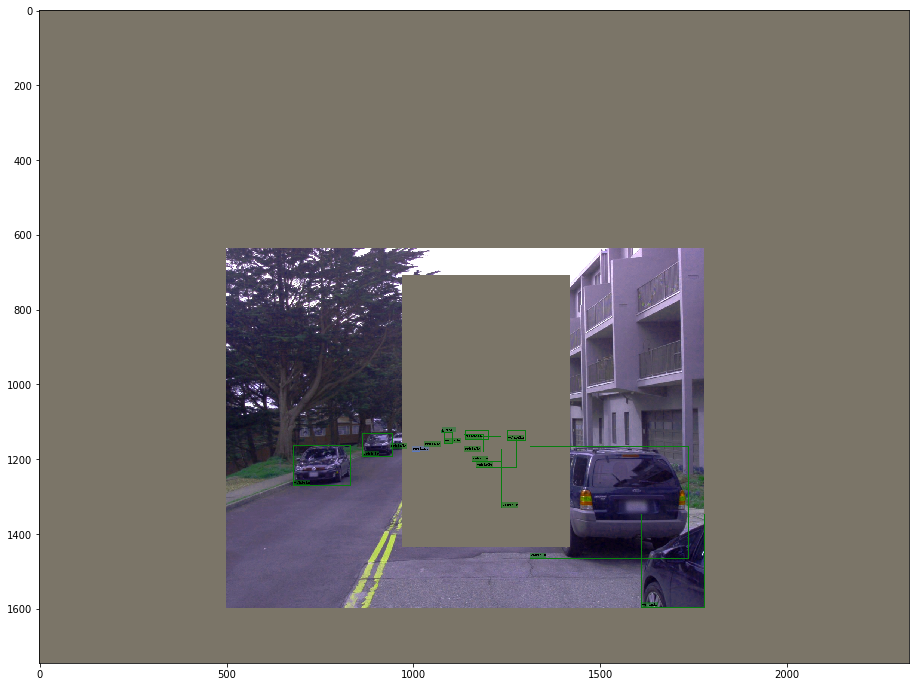

In [28]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [29]:
#t5=RandomMirror()
img,box,label=t5(img,box,label)

In [30]:
# print('img',img)
# print('box',box)
# print('label',label)

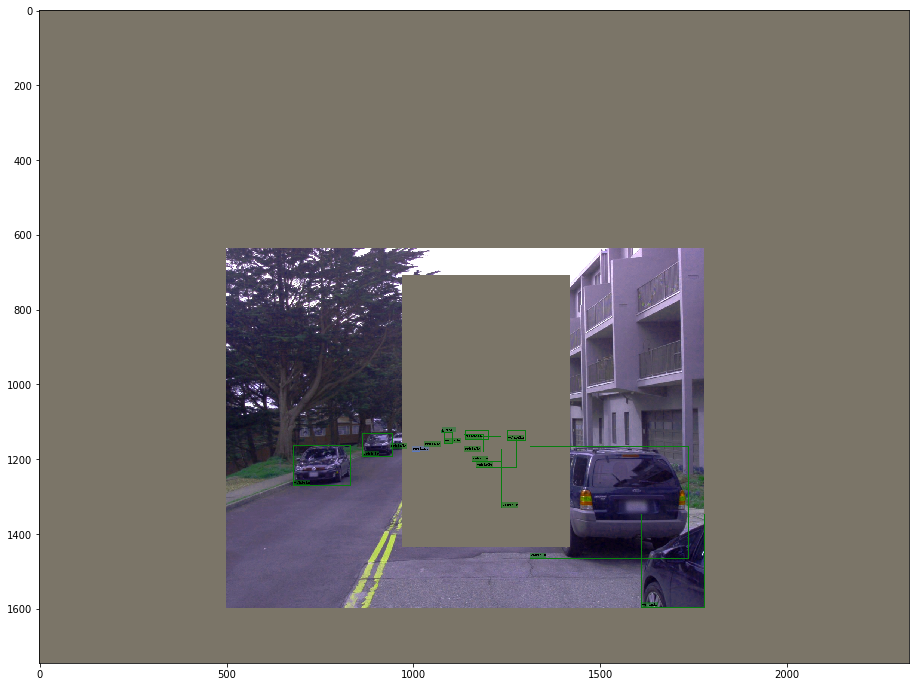

In [31]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [32]:
#t6=ToPercentCoords(),
img,box,label=t6(img,box,label)

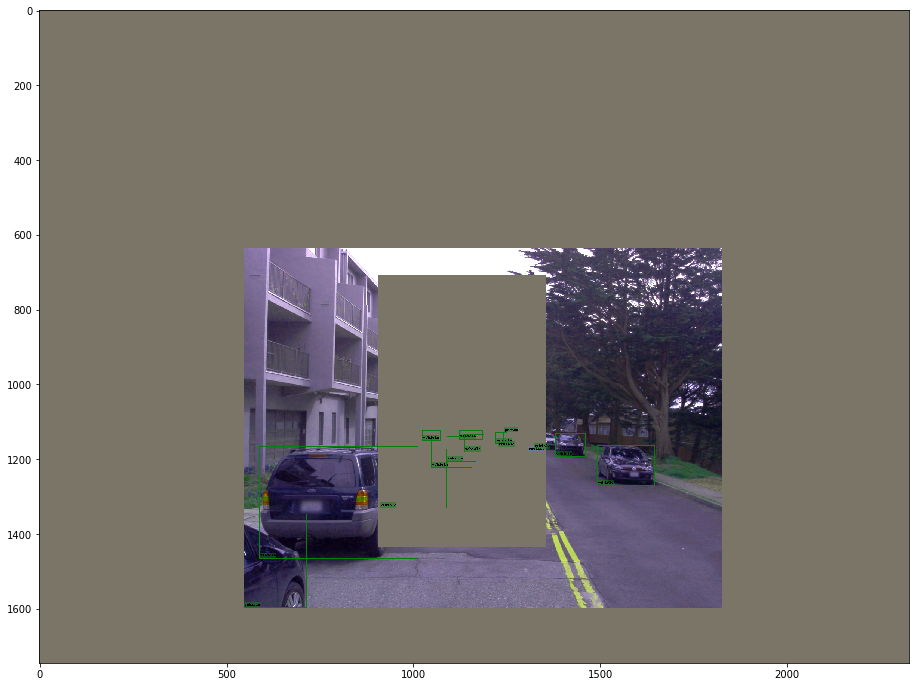

In [33]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [34]:
#t7=Resize(cfg.INPUT.IMAGE_SIZE),
img,box,label=t7(img,box,label)

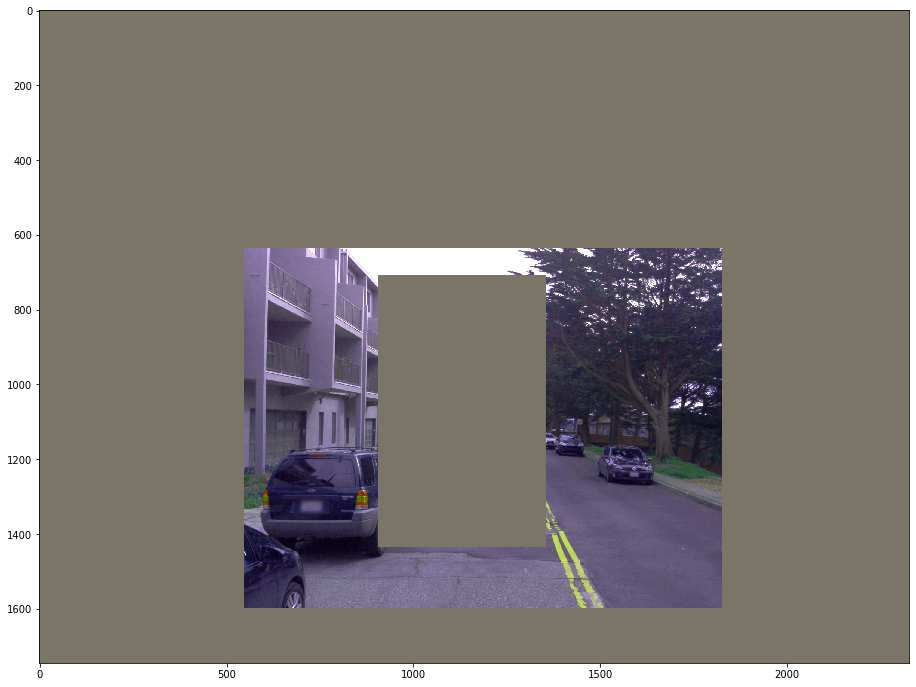

In [35]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [36]:
#t8=SubtractMeans(cfg.INPUT.PIXEL_MEAN),
img,box,label=t8(img,box,label)

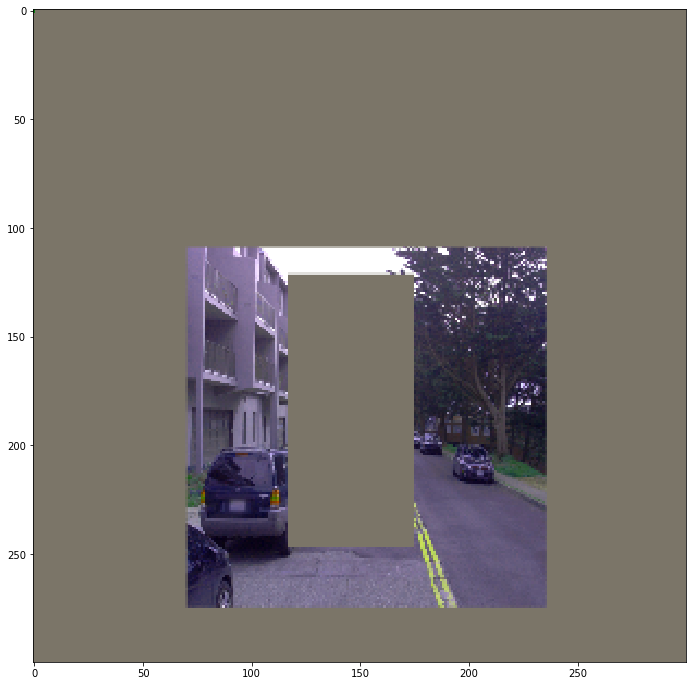

In [37]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)

In [38]:
#Try to show the box_location:
t_absolute_coor=ToAbsoluteCoords()

In [39]:
img,box,label=t_absolute_coor(img,box,label)

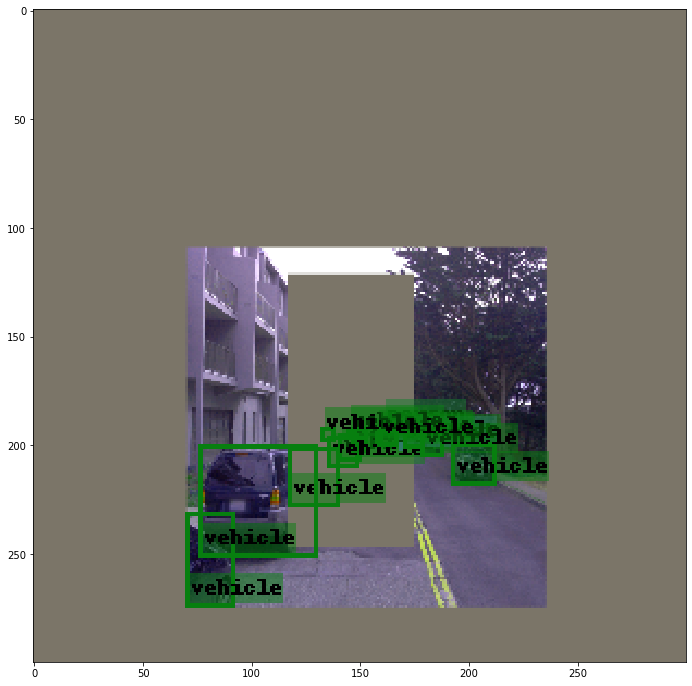

In [40]:
#Show the pic
image_show = draw_boxes(
    img.astype('uint8'), box, label, class_name_map=class_test
)
plt.figure(figsize=(20, 12))
plt.imshow(image_show)